In [47]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

import matplotlib.cm as cm
    
import sys 
sys.path.insert(0, '../src/')

from astropy.table import Table
#import galhalo
import anaclass
import os
import warnings; warnings.simplefilter('ignore')


### setting up the SAGA samples

In [49]:
massmat = anaclass.MassMat("../../data/3000_12_8/acc_surv_mass.npy")
massmat.prep_data()

In [50]:
def cumulative(lgMs_1D):
    """

    Args:
        Ms (numpy): 1D mass array
        mass_bins (numpy): mass bins

    Returns:
        CSMF (numpy): counts in each bin
    """

    mass_bins = np.linspace(4,11,45)

    N = np.histogram(lgMs_1D, bins=mass_bins)[0]
    Nsub = np.sum(N)
    stat = Nsub-np.cumsum(N) 
    return np.insert(stat, 0, Nsub) #to add the missing index

def dex_sampler(lgMs_1D, dex, N_samples):
    """    
    returns the stellar mass [M_sun] plus a random sample of a lognormal distribution for a single array
    """
    scatter = np.random.normal(loc=0, scale=dex, size=(N_samples, lgMs_1D.shape[0])) # the standard normal PDF
    return lgMs_1D + scatter

def SHMR(lgMh_2D, alpha=1.85, delta=0.2, sigma=0.5, N_samples=1000):

    """
    Returns: the log stellar mass array with an added dimension corresponding to the random samples
    """

    M_star_a = 10 # these are the anchor points
    M_halo_a = 11.67

    #print("not normalizing for the upscatter and assuming a 2D input array")
    lgMs_2D = alpha*(lgMh_2D-M_halo_a) - delta*(lgMh_2D-M_halo_a)**2 + M_star_a
    lgMs_3D = np.apply_along_axis(dex_sampler, 1, lgMs_2D, dex=sigma, N_samples=N_samples)
    return lgMs_3D

def MODEL(data):
    
    #alpha, delta, sigma = theta

    #lgMhs_2D = np.load("../../../data/3000_12_8/truth_lgMh.npy")
    lgMs_3D = SHMR(data) # will be a 3D array if sigma is non zero

    count_mat = np.zeros(shape=(lgMs_3D.shape[1], lgMs_3D.shape[0], 45)) #shouldn't be hard coded in!
    for i in range(lgMs_3D.shape[1]): # to measure a cumulative mass function for each random sample
        count_mat[i] = np.apply_along_axis(cumulative, 1, lgMs_3D[:,i,:])

    counts = np.average(count_mat, axis=0) # to average across all the random samples
    quant = np.percentile(counts, np.array([5, 50, 95]), axis=0, method="closest_observation") # median and scatter

    S1 = quant[2, 18] - quant[0, 18] #18, 22, 26 corresponds to 6.5, 7, 7.5 Msol
    S2 = quant[2, 22] - quant[0, 22]
    S3 = quant[2, 26] - quant[0, 26]
    N1 = quant[1, 18]
    N2 = quant[1, 22]
    N3 = quant[1, 26]

    model = np.array([N1, N2, N3, S1, S2, S3])

    return model

In [51]:
Nsamp = 100
Nsets = int(massmat.lgMh.shape[0]/Nsamp) #dividing by the number of samples
set_ind = np.arange(0,Nsets)*Nsamp
print("dividing your sample into", Nsets-1, "sets")

real_ind = np.arange(0,Nsets)*100

dividing your sample into 30 sets


In [52]:
mat = np.zeros(shape=(Nsets-1, 6))
for i in range(Nsets-1):
    mat[i] = MODEL(massmat.lgMh[real_ind[i]:real_ind[i+1]])

In [53]:
sampave = np.average(mat,axis=0)

sampstd = np.std(mat, axis=0)
#C = np.cov(mat, rowvar=True)

<ErrorbarContainer object of 3 artists>

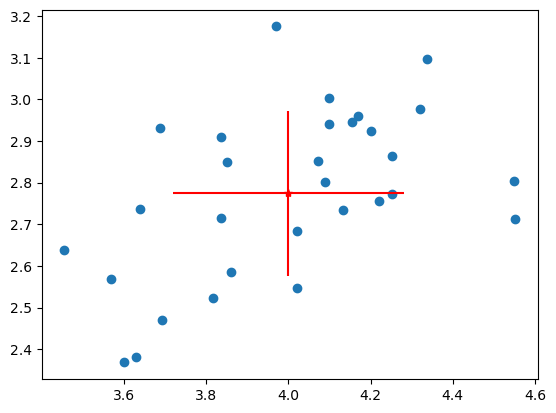

In [54]:
i,j = 4,5
plt.scatter(mat[:,i], mat[:,j])
plt.errorbar(sampave[i], sampave[j], xerr=sampstd[i], yerr=sampstd[j], color="red", fmt="*")


In [55]:
# now for the truth values!!

print(mat[5]) #taken randomly
print(sampstd)

[5.419 2.747 1.228 5.972 4.099 3.003]
[0.22681122 0.14130802 0.08656209 0.43580034 0.28146944 0.19810474]


In [57]:
truth_data = massmat.lgMh[real_ind[5]:real_ind[6]]

In [59]:
np.save("../../data/3000_12_8/truth_lgMh.npy",  truth_data)

In [56]:
# plt.figure(figsize=(8, 8))
# plt.plot(massmat.mass_bins, tmp_quant[1], color="black")
# plt.fill_between(massmat.mass_bins, y1=tmp_quant[0], y2=tmp_quant[2], color="grey", alpha=0.2)
# plt.scatter(x,10**y, color="red", lw=3, label="fitting points", marker=".")
# plt.ylim(0.5, 10**(2.5))
# plt.plot(xs, ys, color="green", label="scatter")
# plt.plot(massmat.mass_bins, 10**(a*massmat.mass_bins + b), color="blue", ls="--", label="polyfit")
# plt.xlabel("log m$_{stellar}$ (M$_\odot$)", fontsize=15)
# plt.ylabel("log N (> m$_{stellar}$)", fontsize=15)
# plt.yscale("log")
# plt.legend(fontsize=12)
# plt.xlim(3.5,10)
# plt.show()